# Homework 2

In [1]:
import rpy2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%load_ext rpy2.ipython

## Stuff from lecture

In [2]:
%%R -o d
.libPaths("C:/Users/ville_000/Documents/R/win-library/3.6")
library(rstan)
library(rethinking)
data(Howell1)
d = Howell1

D:\condaenvs\dev\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


### Exploring data

In [3]:
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


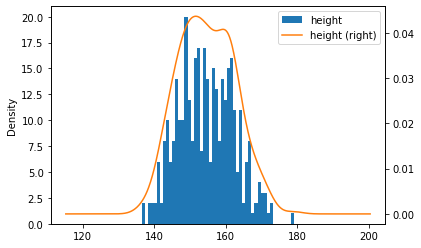

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
_ = d.loc[d["age"]>=18,["height"]].plot.hist(ax=ax, bins=50)
_ = d.loc[d["age"]>=18,["height"]].plot.kde(ax=ax, secondary_y=True)

### Build a model for height as in lecture

\begin{align}
 h_i \sim N(\mu, \sigma) \\
 \mu \sim N(178, 20) \\
 \sigma \sim \text{Uniform}(0, 50)
\end{align}

#### Predictive prior distribution

In [5]:
sample_mu = np.random.normal(loc=178, scale=20, size=10000)
sample_sigma = np.random.uniform(low=0, high=50, size=10000)
prior_h = pd.DataFrame(np.random.normal(loc=sample_mu, scale=sample_sigma))

(0, 300)

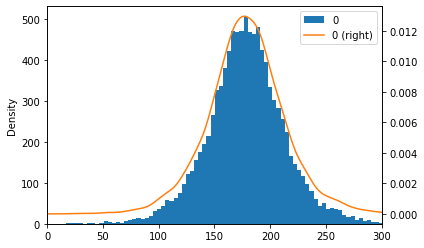

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
_ = prior_h.plot.hist(ax=ax, bins=100)
_ = prior_h.plot.kde(ax=ax, secondary_y=True)
ax.set_xlim(0,300)

#### Get posterior distribution using quadratic approximation (Gaussian)
Function *quap* in the rethinking package. Quadratic approximation approximates posterior as (multi-dimensional) Gaussian distribution.

In [7]:
# Frame with only adults in it
d_adults = d[d["age"] >= 18]

In [8]:
%%R -i d_adults -o summary,sample_posterior,summmary_samples 

# Define model
flist = alist(
    height ~ dnorm(mu, sigma),
    mu ~ dnorm(178, 20),
    sigma ~ dunif(0, 50)
)

# Calculate draws from posterior
# Outputs list of means and convariance matrices (between parameters)
# Enough to describe (multi-dimensional) normal distribution
model = quap(flist, data=d_adults)

# Summary of results
# Mean and std of marginal distribution of each parameter
summary = precis(model)

# Draw samples from the (Gaussian approximated) posterior
sample_posterior = extract.samples(model, n=10000)

# Similar summary for draws as for analytical solution above
summmary_samples = precis(sample_posterior)

D:\condaenvs\dev\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [9]:
print(summary)
print(summmary_samples) # histogram prtins funny, use display for that

        mean   sd   5.5%  94.5%

mu    154.61 0.41 153.95 155.27

sigma   7.73 0.29   7.27   8.20

quap posterior: 10000 samples from model

        mean   sd   5.5%  94.5%

mu    154.62 0.41 153.96 155.26

sigma   7.74 0.29   7.27   8.20

                                                                                             histogram

mu                                                    <U+2581><U+2581><U+2585><U+2587><U+2582><U+2581>

sigma <U+2581><U+2581><U+2581><U+2582><U+2585><U+2587><U+2587><U+2583><U+2581><U+2581><U+2581><U+2581>



### Model for height with weight as predictor

\begin{align}
 h_i \sim N(\mu, \sigma) \qquad & \text{likelihood} \\
 \mu_i = \alpha + \beta (x_i - \bar{x}) \qquad & \text{linear model}  \\
 \alpha \sim N(178, 20) \qquad & \text{prior}  \\
 \sigma \sim \text{Uniform}(0, 50) \qquad & \text{prior}  \\
 \beta \sim N(0, 10) \qquad & \text{prior} 
\end{align}

#### Prior predictive distribution for $\mu$

In [10]:
# Hundred draws out pf prior predictive distribution
N = 100

# Draw values for alpha and beta
alpha = np.random.normal(loc=178, scale=20, size=N)
beta = np.random.normal(loc=0, scale=10, size=N)

min_p = d_adults["weight"].min()
max_p = d_adults["weight"].max()

# Calculate mu
x_grid = np.arange(min_p, max_p, 0.2)
xbar = d_adults["weight"].mean()

mu = np.empty((len(x_grid),N))
for i,(a,b) in enumerate(zip(alpha, beta)):
    mu[:,i] = a + b * (x_grid-xbar)
mu = pd.DataFrame(mu)
mu.index = x_grid

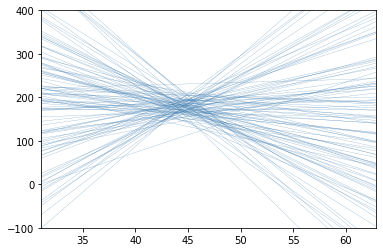

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
_ = mu.plot(ax=ax, legend=False, color="steelblue", linewidth=0.2)
_ = ax.set_ylim(-100,400)

## Question 1
The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.